<h1 p align="center">
CONFUSION MATRIX GENERATION FOR REMOTE SENSING APPLICATIONS
</p>

<h3 p align="center">
|| COALMINE FIRE DETECTION | PYTHON | SKLEARN ||
</p>

This code is a part of a fire detection algorithm developed by Philip et. al. (2022), where the generated and reference fire maps are subjected to comparison. 

*   **Input Image 1:** From the reference shapefile input file, pixel value corresponding to given latitude and longitude is **read** (Step [7])

*   **Input Image 2:** From the input Landsat image, pixel value corresponding to given latitude and longitude is **extracted**   (Step [8])

* **Function:** Compares the values retrieved from Input Image 1 and Input Image 2 and generates confusion matrix, 
which is further used for accuracy assessments (not part of this code).




#####Note: 
*If you want to compare all the points between the two input images instead of certain points decided by (lat long), you can simply ignore the step where the extraction is performed, and directly read each single pixel value to dataframe.*

---


### **Disclaimer:** 

The below python  based program is intended for educational and informative use only and author(s) does not claim to be an authority. Certain parts of program and the logical  structure are based on multiple references and  author(s) claims no credit and accepts no responsibility for the  correctness, completeness or  quality of the information provided. 

**Bijo George Philip**

Date: 23.06.2022



--------

> **START OF CODE**

### 1. Setting up Environment

In [1]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
#Mounting the workspace
%cd /content/drive/MyDrive/workspace

/content/drive/MyDrive/workspace


In [3]:
#Check Python Version
!python --version

Python 3.7.13


In [4]:
%%capture
#Installing necessary libraries
!pip install geopandas
!pip install matplotlib
!pip install rasterio
!pip install beautifultable

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import precision_score,matthews_corrcoef,f1_score,recall_score
from beautifultable import BeautifulTable
from osgeo import gdal,gdal_array
import os
import glob
import warnings
#Import necessary libraries
import rasterio
import geopandas as gpd

# Inline Definitions
%matplotlib inline

### 2. Main Code

#### 2.1 Data Preparation

In [6]:
# Open the Landsat 8 Predicted Coalmine Fire Map
l8_ref_map_input = rasterio.open('Output_Map.tif')

# Print the number of input bands
print("Number of Bands:",l8_ref_map_input.count)

Number of Bands: 1


In [7]:
# Read points from Reference (Input) shapefile
shp = gpd.read_file('Input_Shapefile/Fire_Pixel_Points.shp')

# Create a dataframe and extract the coordinates of the point locations
shp_df = shp[['Fire_Pixel','Fire_Sts','Latitude', 'Longitude']]
shp_df.index = range(len(shp_df))

# Extract Coordinates
coords = [(x,y) for x, y in zip(shp_df.Longitude, shp_df.Latitude)]
print(coords)

[(438433.0096, 2630143.939), (438464.4991, 2630141.201), (438467.9219, 2630115.188), (438439.1706, 2630115.188), (438404.9428, 2630086.437), (438405.6274, 2630055.632), (438367.9769, 2630056.316), (438044.1826, 2630267.502), (438017.485, 2630265.106), (438048.9745, 2630238.75), (438046.9208, 2630203.496), (438014.0622, 2630170.637), (438287.1995, 2630176.113), (437771.7299, 2629634.973), (437779.6023, 2629602.457), (437803.904, 2629723.965), (437901.453, 2629786.944), (438735.2404, 2627205.147), (438738.6632, 2627235.952), (438731.1331, 2627177.765), (433487.4454, 2630295.226), (433515.1699, 2630266.475), (433448.0835, 2630297.964), (433544.2634, 2630269.213), (433487.1031, 2630235.67), (433457.6673, 2630263.052), (433547.0016, 2630201.784), (433516.1967, 2630175.429), (432792.2803, 2630201.1), (432765.5827, 2630203.153), (432793.3071, 2630177.14), (431589.8602, 2632426.586), (431597.0481, 2632389.278), (431624.7725, 2632422.479), (431624.7725, 2632364.634), (433843.0715, 2631646.194),

In [8]:
# Suppress Warning
warnings.simplefilter("ignore")

# Sample the raster at every point location and extact predicted fire pixel values in DataFrame
shp_df['Fire_Pixel_Predicted'] = [x[0] for x in l8_ref_map_input.sample(coords)]


In [9]:
# Print Raw Output Dataframe
display(shp_df)

,Fire_Pixel,Fire_Sts,Latitude,Longitude,Fire_Pixel_Predicted
0,Present,1,2630143.939,438433.0096,1
1,Present,1,2630141.201,438464.4991,0
2,Present,1,2630115.188,438467.9219,1
3,Present,1,2630115.188,438439.1706,1
4,Present,1,2630086.437,438404.9428,1
...,...,...,...,...,...
95,Absent,0,2630205.121,426134.4741,0
96,Absent,0,2635752.067,428864.1353,0
97,Absent,0,2637496.654,448214.7804,1
98,Absent,0,2637494.943,448240.7934,0


In [10]:
# Prepare the Final Dataframe for Comparison
df_final = pd.DataFrame(shp_df, columns=['Fire_Sts','Fire_Pixel_Predicted'])

# Rename Columns and Print Output
df_final.rename(columns = {'Fire_Sts':'Fire_Pixel_Reference'}, inplace = True)
display(df_final)

,Fire_Pixel_Reference,Fire_Pixel_Predicted
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
95,0,0
96,0,0
97,0,1
98,0,0


#### 2.2 Confusion Matrix Generation

**NOTE:**

The confusion matrix generates four values based on its combinations as below:
*   **True Positive (TP):** Samples that are actually positive, and correctly classified as positive.

*   **True Negative (TN):** Samples that are actually negative, and correctly classified as negative.

*   **False Positive (FP):** Samples that are actually negative, but incorrectly classified as positive.

*   **False Negative (FN):** Samples that are actually positive, but incorrectly classified as negative.

In [11]:
# Generate Simple Confusion matrix
cm_simple = pd.crosstab(df_final['Fire_Pixel_Reference'], df_final['Fire_Pixel_Predicted'], rownames=['Actual'], colnames=['Predicted'])
print (cm_simple)

Predicted   0   1
Actual           
0          48   2
1           2  48


In [12]:
# Convert Dataframe Values to numpy array for ref
ref = df_final['Fire_Pixel_Reference'].to_numpy()
#Convert string array to int array
ref = ref.astype(np.uint8)

# Convert Dataframe Values to numpy array for pred
pred = df_final['Fire_Pixel_Predicted'].to_numpy()

In [13]:
# Generate Confusion Matrix
print("Confusion Matrix:")
cf_matrix = confusion_matrix(ref,pred)
print(cf_matrix)
print("\nAccuracy(%):\n",accuracy_score(ref,pred)*100)
print("\nClassification Report:\n")
print(classification_report(ref,pred))

Confusion Matrix:
[[48  2]
 [ 2 48]]

Accuracy(%):
 96.0

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.96      0.96      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



#### 2.3 Display Confusion Matrix

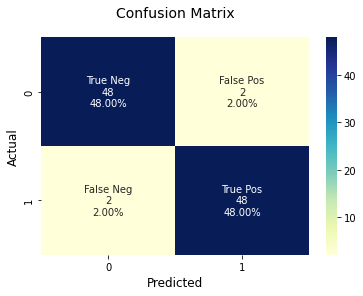

In [14]:
# Display Confusion Matrix
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
cf_pretty = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu')
cf_pretty.set_xlabel('Predicted', fontsize=12)
cf_pretty.set_ylabel('Actual', fontsize=12)
cf_pretty.set_title('Confusion Matrix', pad=20, fontsize=14, horizontalalignment='center')
display(cf_pretty)

> **END OF CODE**

----